# Flight Delay Absorption Classification--Baseline Model

# Package Preparation

In [37]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import shap

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Data loading and merging

* Task: Analyze the provided flight and weather data from "flights.csv" and "weather.csv" by merging them based on date, airport code, and time specifications. Then download the merged data as a CSV file for classification model building.

In [ ]:
# Set up project root directory if you're running the notebook locally
# Get the directory of the current notebook
notebook_dir = Path().resolve()

project_root = notebook_dir.parent.parent

print(project_root)

/


In [3]:
FLIGHT_PATH = "/content/drive/My Drive/Capstone Project AA/Flight_Data/AA_FLIGHT_RECORD_PROCESSED/aa_flights_entire.csv" # Change according to actual directories
#FLIGHT_PATH = project_root / "src/data/processed/aa_flights_entire.csv" # Change according to actual directories
#WEATHER_PATH = project_root / "src/data/processed/All_Hubs_Weather_EDA.csv"
WEATHER_PATH = "/content/drive/My Drive/Capstone Project AA/Weather_Data_Hubs/All_Hubs_Weather_EDA.csv"

flight_df = pd.read_csv(FLIGHT_PATH)
weather_df = pd.read_csv(WEATHER_PATH)

print("Flight DataFrame head:")
display(flight_df.head())

print("\nWeather DataFrame head:")
display(weather_df.head())

Flight DataFrame head:


,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,ORIGIN_UTC_OFFSET,DEST_UTC_OFFSET,CRS_DEP_TIME_UTC_MIN,DEP_TIME_UTC_MIN,CRS_ARR_TIME_UTC_MIN,ARR_TIME_UTC_MIN,CRS_DEP_TIME_UTC_HHMM,DEP_TIME_UTC_HHMM,CRS_ARR_TIME_UTC_HHMM,ARR_TIME_UTC_HHMM
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,...,-5,-8,750,746.0,1132,1134.0,1230,1226,1852,1854
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,...,-5,-8,750,743.0,1132,1117.0,1230,1223,1852,1837
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,...,-5,-8,750,787.0,1132,1180.0,1230,1307,1852,1940
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,...,-5,-8,750,747.0,1132,1119.0,1230,1227,1852,1839
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,...,-5,-8,750,745.0,1132,1126.0,1230,1225,1852,1846



Weather DataFrame head:


,station,time,temp_C,dewpoint_C,wind_dir_deg,wind_speed_kt,visibility_mi,pressure_mb,weather,Sky
0,KDFW,2023-01-01 00:00:00,18.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"
1,KDFW,2023-01-01 00:00:00,18.3,6.7,180.0,7.0,NaN,NaN,NaN,NaN
2,KDFW,2023-01-01 00:05:00,18.0,7.0,180.0,8.0,10.0,1007.792045,NaN,"[('CLR', None, None)]"
3,KDFW,2023-01-01 00:10:00,19.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"
4,KDFW,2023-01-01 00:15:00,19.0,7.0,180.0,7.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"


In [4]:
# Convert 'FL_DATE' in flight_df to datetime objects
flight_df['FL_DATE'] = pd.to_datetime(flight_df['FL_DATE'])

# Convert 'time' in weather_df to datetime objects
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Create combined datetime columns for merging in flight_df
def combine_date_time(row, date_col, time_col):
    if pd.isna(row[date_col]) or pd.isna(row[time_col]):
        return pd.NaT
    # Ensure the time column is treated as a string in HH:MM format
    # Assuming the original time columns (DEP_TIME, ARR_TIME) are in a format like HMM or HHMM
    # Convert to string, pad with leading zeros if necessary, and format
    time_str = str(int(row[time_col])).zfill(4)
    hour = time_str[:2]
    minute = time_str[2:]
    # Combine date and time strings and convert to datetime
    try:
        return pd.to_datetime(f"{row[date_col].date()} {hour}:{minute}")
    except ValueError:
        return pd.NaT


flight_df['DEP_DATETIME'] = flight_df.apply(lambda row: combine_date_time(row, 'FL_DATE', 'DEP_TIME'), axis=1)
flight_df['ARR_DATETIME'] = flight_df.apply(lambda row: combine_date_time(row, 'FL_DATE', 'ARR_TIME'), axis=1)

# Create columns for 1 hour before arrival
flight_df['ARR_DATETIME_MINUS_1H'] = flight_df['ARR_DATETIME'] - pd.Timedelta(hours=1)

# Extract airport code from 'station' in weather_df
weather_df['airport_code'] = weather_df['station'].str[-3:]

# Round weather time to the nearest 5 minutes and create combined datetime
weather_df['weather_time_rounded'] = weather_df['time'].dt.round('5min')


display(flight_df.head())
display(weather_df.head())

,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,DEP_TIME_UTC_MIN,CRS_ARR_TIME_UTC_MIN,ARR_TIME_UTC_MIN,CRS_DEP_TIME_UTC_HHMM,DEP_TIME_UTC_HHMM,CRS_ARR_TIME_UTC_HHMM,ARR_TIME_UTC_HHMM,DEP_DATETIME,ARR_DATETIME,ARR_DATETIME_MINUS_1H
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,...,746.0,1132,1134.0,1230,1226,1852,1854,2023-01-01 07:26:00,2023-01-01 10:54:00,2023-01-01 09:54:00
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,...,743.0,1132,1117.0,1230,1223,1852,1837,2023-01-02 07:23:00,2023-01-02 10:37:00,2023-01-02 09:37:00
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,...,787.0,1132,1180.0,1230,1307,1852,1940,2023-01-03 08:07:00,2023-01-03 11:40:00,2023-01-03 10:40:00
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,...,747.0,1132,1119.0,1230,1227,1852,1839,2023-01-04 07:27:00,2023-01-04 10:39:00,2023-01-04 09:39:00
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,...,745.0,1132,1126.0,1230,1225,1852,1846,2023-01-05 07:25:00,2023-01-05 10:46:00,2023-01-05 09:46:00


,station,time,temp_C,dewpoint_C,wind_dir_deg,wind_speed_kt,visibility_mi,pressure_mb,weather,Sky,airport_code,weather_time_rounded
0,KDFW,2023-01-01 00:00:00,18.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:00:00
1,KDFW,2023-01-01 00:00:00,18.3,6.7,180.0,7.0,NaN,NaN,NaN,NaN,DFW,2023-01-01 00:00:00
2,KDFW,2023-01-01 00:05:00,18.0,7.0,180.0,8.0,10.0,1007.792045,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:05:00
3,KDFW,2023-01-01 00:10:00,19.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:10:00
4,KDFW,2023-01-01 00:15:00,19.0,7.0,180.0,7.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:15:00


* Task: Drop missing values in departure/arrival time for valid merging

In [5]:
# Drop rows with missing departure datetime
flight_df_dep = flight_df.dropna(subset=['DEP_DATETIME']).sort_values('DEP_DATETIME')

# Step 1: Merge flight data with departure weather data
merged_dep_weather = pd.merge_asof(
    flight_df_dep,
    weather_df.sort_values('weather_time_rounded'),
    left_on='DEP_DATETIME',
    right_on='weather_time_rounded',
    left_by='ORIGIN',
    right_by='airport_code',
    direction='nearest',
    tolerance=pd.Timedelta('5 minutes')
)

# Select and rename weather columns for departure
departure_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
# Ensure all columns exist before renaming
existing_departure_weather_cols = [col for col in departure_weather_cols if col in merged_dep_weather.columns]
rename_dict_dep = {col: f'DEP_{col}' for col in existing_departure_weather_cols}
merged_dep_weather = merged_dep_weather.rename(columns=rename_dict_dep)


# Drop weather_time_rounded and airport_code from departure merge result to avoid conflicts in the next merge
merged_dep_weather = merged_dep_weather.drop(columns=['weather_time_rounded', 'airport_code'], errors='ignore')

# Drop rows with missing arrival datetime from the departure merged dataframe
merged_dep_weather_arr = merged_dep_weather.dropna(subset=['ARR_DATETIME']).sort_values('ARR_DATETIME')

# Step 2: Merge flight data with arrival weather data
merged_arr_weather = pd.merge_asof(
    merged_dep_weather_arr,
    weather_df.sort_values('weather_time_rounded'),
    # left_on='ARR_DATETIME',
    left_on='ARR_DATETIME_MINUS_1H', # Using 1 hour before arrival time for weather matching
    right_on='weather_time_rounded',
    left_by='DEST',
    right_by='airport_code',
    direction='nearest',
    tolerance=pd.Timedelta('5 minutes')
)

# Select and rename weather columns for arrival
arrival_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
# Ensure all columns exist before renaming
existing_arrival_weather_cols = [col for col in arrival_weather_cols if col in merged_arr_weather.columns]
rename_dict_arr = {col: f'ARR_{col}' for col in existing_arrival_weather_cols}
merged_df = merged_arr_weather.rename(columns=rename_dict_arr)

# Drop intermediate columns used for merging and redundant weather columns from the second merge
# We need to be careful here to only drop columns that were not renamed or are truly intermediate
cols_to_drop = [
    'weather_time_rounded', 'airport_code_x', 'airport_code_y', # airport_code might be duplicated with suffixes after merge
    'time_x', 'time_y', # Original time columns from weather_df
    'station_x', 'station_y' # Original station columns from weather_df
]

# Drop original weather columns from the second merge that might still have their original names
# These would be the columns from weather_df that were not successfully merged in the first step
original_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
cols_to_drop.extend(original_weather_cols)


# Also drop weather columns from the first merge that were not renamed, before the second merge happened
# These columns would have the original names and are redundant after the second merge
# Check for columns that should have been renamed but might not have been
potentially_unrenamed_dep_cols = [col for col in departure_weather_cols if f'DEP_{col}' not in merged_df.columns and col in merged_df.columns]
cols_to_drop.extend(potentially_unrenamed_dep_cols)

# Drop the intermediate DEP_DATETIME and ARR_DATETIME if they were not dropped earlier
cols_to_drop.extend(['DEP_DATETIME', 'ARR_DATETIME'])

# Drop columns, ignoring errors for columns that might not exist
merged_df = merged_df.drop(columns=list(set(cols_to_drop)), errors='ignore')

print("Merged DataFrame head:")
display(merged_df.head())

Merged DataFrame head:


,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,DEP_Sky,ARR_temp_C,ARR_dewpoint_C,ARR_wind_dir_deg,ARR_wind_speed_kt,ARR_visibility_mi,ARR_pressure_mb,ARR_weather,ARR_Sky,airport_code
0,2023-01-01,AA,1950,MIA,DFW,2120,2216.0,2228.0,2348,6.0,...,"[('FEW', <metar.Datatypes.distance object at 0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01,AA,1091,CLT,PHL,2240,2240.0,2257.0,23,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01,AA,185,JFK,LAX,2030,2024.0,2047.0,16,8.0,...,"[('CLR', None, None)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01,AA,1245,CLT,DCA,2011,2227.0,2249.0,2130,8.0,...,"[('BKN', <metar.Datatypes.distance object at 0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,AA,2362,MIA,DCA,2118,2116.0,2136.0,2359,9.0,...,"[('SCT', <metar.Datatypes.distance object at 0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(flight_df.columns)

Index(['FL_DATE', 'MKT_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'CRS_ARR_TIME', 'ARR_TIME',
       'WHEELS_ON', 'CANCELLED', 'DIVERTED', 'YEAR', 'MONTH', 'AIRCRAFT_TYPE',
       'DESCRIPTION', 'CRS_DEP_TIME_MIN', 'DEP_TIME_MIN', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_MIN', 'dep_delay', 'arr_delay', 'delta_delay',
       'delay_change_flag', 'ORIGIN_UTC_OFFSET', 'DEST_UTC_OFFSET',
       'CRS_DEP_TIME_UTC_MIN', 'DEP_TIME_UTC_MIN', 'CRS_ARR_TIME_UTC_MIN',
       'ARR_TIME_UTC_MIN', 'CRS_DEP_TIME_UTC_HHMM', 'DEP_TIME_UTC_HHMM',
       'CRS_ARR_TIME_UTC_HHMM', 'ARR_TIME_UTC_HHMM', 'DEP_DATETIME',
       'ARR_DATETIME', 'ARR_DATETIME_MINUS_1H'],
      dtype='object')


* Task: Save merged file

In [7]:
# from google.colab import drive

# Define the path to save the merged DataFrame in your Google Drive
# output_path = "/content/drive/My Drive/Capstone Project AA/merged_flight_weather.csv"

# Define the path to save the merged DataFrame in your project directory
output_path = project_root / "src/data/processed/merged_flight_weather.csv"

# Save the merged DataFrame to a CSV file
merged_df.to_csv(output_path, index=False)

# print(f"Merged data saved to {output_path}")

NameError: name 'project_root' is not defined

## Step 2: Prepare target variable

* Task: Create a new binary column in the `merged_df` DataFrame called `delta_delay_sign` that indicates whether the `delta_delay` is positive (1) or negative (0). This is in accordance with our definition of "flight delay absorption"--whether a flight manages to make up departure delay time in the air.


**Reasoning**:
Calculate delta_delay and create the binary delta_delay_sign column.



In [8]:
merged_df['delta_delay'] = merged_df['arr_delay'] - merged_df['dep_delay']
# Redefine delta_delay_sign: 1 if arrival delay is smaller than departure delay, 0 otherwise
merged_df['delta_delay_sign'] = (merged_df['delta_delay'] < 0).astype(int)
display(merged_df[['arr_delay', 'dep_delay', 'delta_delay', 'delta_delay_sign']].head())

,arr_delay,dep_delay,delta_delay,delta_delay_sign
0,18.0,56.0,-38.0,1
1,-16.0,0.0,-16.0,1
2,-8.0,-6.0,-2.0,1
3,158.0,136.0,22.0,0
4,10.0,-2.0,12.0,0


## Step 1-2 alternative: load merged table directly

In [39]:
MERGED_DATA_PATH = "/content/drive/My Drive/Capstone Project AA/Modeling/merged_data_deploy/model_final.csv"
merged_df = pd.read_csv(MERGED_DATA_PATH)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399618 entries, 0 to 399617
Data columns (total 75 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  399618 non-null  object 
 1   MKT_UNIQUE_CARRIER       399618 non-null  object 
 2   OP_CARRIER_FL_NUM        399618 non-null  int64  
 3   ORIGIN                   399618 non-null  object 
 4   DEST                     399618 non-null  object 
 5   CRS_DEP_TIME             399618 non-null  int64  
 6   DEP_TIME                 399618 non-null  int64  
 7   WHEELS_OFF               399618 non-null  float64
 8   CRS_ARR_TIME             399618 non-null  int64  
 9   ARR_TIME                 399618 non-null  int64  
 10  WHEELS_ON                399618 non-null  float64
 11  CANCELLED                399618 non-null  float64
 12  DIVERTED                 399618 non-null  float64
 13  YEAR                     399618 non-null  int64  
 14  MONT

- Generate ```delta_delay_sign``` based on existing labeling variables

In [40]:
# merged_df['delta_delay_sign'] = (merged_df['delay_label_num'] < 0).astype(int)
merged_df['delta_delay_sign'] = (merged_df['delta_delay'] < 0).astype(int)
display(merged_df[['arr_delay', 'dep_delay', 'delta_delay', 'delta_delay_sign']].head())

,arr_delay,dep_delay,delta_delay,delta_delay_sign
0,16.0,44.0,-28.0,1
1,-24.0,-3.0,-21.0,1
2,-8.0,-6.0,-2.0,1
3,-6.0,6.0,-12.0,1
4,-16.0,0.0,-16.0,1


## Step 3: Feature selection and preprocessing
* Task: Feature selection. Select relevant numerical features and handle any remaining missing values or outliers in those features.


**Reasoning**:
Inspect the merged_df DataFrame to identify all columns with numerical data types and create a list of numerical columns relevant for modeling, including the target variable. Then, identify columns with missing values and their percentages to determine handling strategies.



In [41]:
# Identify numerical columns
# numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
# print("All numerical columns:", numerical_cols)

# Select relevant numerical columns for modeling, including the target
# Exclude text-based columns and the specified columns

# Include directions

relevant_numerical_cols = [
    'DEP_visibility_mi',
    'MONTH',
    'ARR_visibility_mi',
    'ARR_wind_speed_kt',
    'ARR_dewpoint_C',
    'DEP_dewpoint_C',
    'DEP_wind_speed_kt',
    'ARR_temp_C',
    'DEP_pressure_mb',
    'ARR_pressure_mb',
    'DEP_temp_C',
    'CRS_DEP_TIME_UTC_MIN',
    # 'ARR_TIME_UTC_MIN',   # adding this caused data leakage
    'DEP_TIME_UTC_MIN',
    'ARR_wind_dir_deg',
    'DEP_wind_dir_deg',
    'CRS_ARR_TIME_UTC_MIN',
    'AIRCRAFT_TYPE',
    'FLIGHT_DIRECTION_VECTOR', # Add when using preprocessed and premerged data
    'delta_delay_sign' # Include the target variable
]

# Filter numerical_cols to include only those in relevant_numerical_cols
numerical_cols = [col for col in relevant_numerical_cols if col in merged_df.columns]

print("\nRelevant numerical columns for modeling:", numerical_cols)

# Identify missing values in selected numerical columns
missing_numerical_values = merged_df[numerical_cols].isnull().sum()
print("\nMissing values per relevant numerical column:")
print(missing_numerical_values[missing_numerical_values > 0])

# Calculate percentage of missing values
missing_numerical_percentage = merged_df[numerical_cols].isnull().mean() * 100
print("\nPercentage of missing values per relevant numerical column:")
print(missing_numerical_percentage[missing_numerical_percentage > 0])


Relevant numerical columns for modeling: ['DEP_visibility_mi', 'MONTH', 'ARR_visibility_mi', 'ARR_wind_speed_kt', 'ARR_dewpoint_C', 'DEP_dewpoint_C', 'DEP_wind_speed_kt', 'ARR_temp_C', 'DEP_pressure_mb', 'ARR_pressure_mb', 'DEP_temp_C', 'CRS_DEP_TIME_UTC_MIN', 'DEP_TIME_UTC_MIN', 'ARR_wind_dir_deg', 'DEP_wind_dir_deg', 'CRS_ARR_TIME_UTC_MIN', 'AIRCRAFT_TYPE', 'FLIGHT_DIRECTION_VECTOR', 'delta_delay_sign']

Missing values per relevant numerical column:
DEP_visibility_mi      625
ARR_visibility_mi      756
ARR_wind_speed_kt    26677
ARR_dewpoint_C        9891
DEP_dewpoint_C        9361
DEP_wind_speed_kt    24808
ARR_temp_C            6223
DEP_pressure_mb        387
ARR_pressure_mb        387
DEP_temp_C            6323
ARR_wind_dir_deg     29961
DEP_wind_dir_deg     27749
dtype: int64

Percentage of missing values per relevant numerical column:
DEP_visibility_mi    0.156399
ARR_visibility_mi    0.189181
ARR_wind_speed_kt    6.675625
ARR_dewpoint_C       2.475114
DEP_dewpoint_C       2.34

In [42]:
print(merged_df['delta_delay_sign'].value_counts())
print(merged_df['delta_delay_sign'].value_counts(normalize=True))

delta_delay_sign
1    292552
0    107066
Name: count, dtype: int64
delta_delay_sign
1    0.732079
0    0.267921
Name: proportion, dtype: float64


* Task: Split data. Split the processed data into training and testing sets.


In [43]:
# Select only the relevant numerical columns for X
X = merged_df[numerical_cols].drop(columns=['delta_delay_sign']) # Exclude the target

# Define target variable y
y = merged_df['delta_delay_sign']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Identify columns in X_train with missing values
cols_to_impute_median = X_train.columns[X_train.isnull().any()].tolist()

# Impute missing values with the median for the identified columns in X_train
for col in cols_to_impute_median:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)

# Impute missing values in X_test with the median from X_train for the same columns
for col in cols_to_impute_median:
    median_val = X_train[col].median() # Use median from X_train
    X_test[col] = X_test[col].fillna(median_val)


# Check for remaining missing values in X_train and X_test
print("Missing values in X_train after imputation:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nMissing values in X_test after imputation:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])


# Identify and handle outliers using capping (1st and 99th percentile)
# Exclude binary columns and those where outliers are expected (like delay times)
# Use columns from the updated X_train for capping
# cols_to_cap = X_train.columns.tolist()


# for col in cols_to_cap:
#     if col in X_train.columns: # Check if column exists in X_train
#         lower_bound = X_train[col].quantile(0.01)
#         upper_bound = X_train[col].quantile(0.99)
#         X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
#         X_test[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)


# Display descriptive statistics of processed numerical features in X_train
print("\nDescriptive statistics of X_train after handling missing values and outliers:")
display(X_train.describe())

# Verify no remaining missing values in the imputed columns in X_train and X_test
print("\nMissing values in X_train after capping and imputation verification:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nMissing values in X_test after capping and imputation verification:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

Missing values in X_train after imputation:
Series([], dtype: int64)

Missing values in X_test after imputation:
Series([], dtype: int64)

Descriptive statistics of X_train after handling missing values and outliers:


,DEP_visibility_mi,MONTH,ARR_visibility_mi,ARR_wind_speed_kt,ARR_dewpoint_C,DEP_dewpoint_C,DEP_wind_speed_kt,ARR_temp_C,DEP_pressure_mb,ARR_pressure_mb,DEP_temp_C,CRS_DEP_TIME_UTC_MIN,DEP_TIME_UTC_MIN,ARR_wind_dir_deg,DEP_wind_dir_deg,CRS_ARR_TIME_UTC_MIN,AIRCRAFT_TYPE,FLIGHT_DIRECTION_VECTOR
count,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000
mean,9.432796,6.567327,9.440547,6.724827,9.855625,9.884941,6.316718,18.366512,1016.020782,1015.951763,17.769294,1102.980150,1107.603777,167.936183,167.424099,1222.240133,732.751356,167.816503
std,1.743088,3.443246,1.731838,4.101156,9.430322,9.420801,4.050561,9.467134,6.450963,6.418400,9.477859,312.723843,319.689199,104.937387,106.760475,326.440275,81.633268,102.458172
min,0.000000,1.000000,0.000000,0.000000,-28.000000,-28.000000,0.000000,-61.000000,981.716780,980.362221,-61.000000,250.000000,241.000000,0.000000,0.000000,241.000000,614.000000,11.000000
25%,10.000000,4.000000,10.000000,4.000000,3.000000,3.000000,4.000000,12.000000,1012.194362,1011.855722,11.000000,840.000000,837.000000,80.000000,80.000000,982.000000,698.000000,67.000000
50%,10.000000,7.000000,10.000000,7.000000,11.000000,11.000000,5.000000,19.000000,1015.580760,1015.580760,18.000000,1099.000000,1105.000000,170.000000,170.000000,1231.000000,699.000000,176.000000
75%,10.000000,10.000000,10.000000,9.000000,18.000000,18.000000,9.000000,26.000000,1019.983078,1019.644438,25.000000,1345.000000,1357.000000,250.000000,250.000000,1490.000000,838.000000,270.000000
max,10.000000,12.000000,110.000000,70.000000,27.000000,27.000000,70.000000,48.000000,1049.106100,1049.106100,48.000000,1919.000000,1920.000000,360.000000,360.000000,1919.000000,889.000000,357.000000



Missing values in X_train after capping and imputation verification:
Series([], dtype: int64)

Missing values in X_test after capping and imputation verification:
Series([], dtype: int64)


In [44]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 4: Model selection and training

* Task: Model selection. For baseline, we choose a most simple logistic regression model which could serve as comparison to other advanced models.

**Reasoning**:
Choose and train a Logistic Regression model on the training data using the selected features.

In [45]:
# Instantiate the Logistic Regression model
# model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # Using liblinear solver for potentially faster convergence on smaller datasets
model = LogisticRegression(random_state=42, solver='lbfgs', class_weight='balanced')

# Train the model on the training data
model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully with updated features.")

Logistic Regression model trained successfully with updated features.


## Evaluate model

### Subtask:
Evaluate the trained model's performance on the testing data using relevant classification metrics (e.g., accuracy, precision, recall, F1-score, ROC AUC).

**Reasoning**:
Evaluate the trained model's performance on the testing data using relevant classification metrics as per the instructions.

In [47]:
# Make predictions on the testing features
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC AUC if the model supports predict_proba (Logistic Regression does)
try:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
except AttributeError:
    roc_auc = "N/A (Model does not support predict_proba)"


# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.5442
Precision: 0.7753
Recall: 0.5315
F1-score: 0.6306
ROC AUC: 0.534917746563591


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Feature importance/interpretation (optional)

### Subtask:
Analyze feature importances to understand which weather, date, or aircraft features are most influential in predicting the delta delay sign.

**Reasoning**:
Access the coefficients of the trained Logistic Regression model, create a pandas Series to store feature names and coefficients, sort them by absolute magnitude, and print the sorted feature importances.

In [48]:
# Access the coefficients of the trained Logistic Regression model
coefficients = model.coef_[0]

# Get the feature names from the training data
feature_names = X_train.columns

# Create a pandas Series to store feature names and coefficients
feature_importances = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute magnitude
sorted_feature_importances = feature_importances.reindex(feature_importances.abs().sort_values(ascending=False).index)

# Print the sorted feature importances
print("Feature Importances (Coefficients) from Logistic Regression with updated features:")
print(sorted_feature_importances)

Feature Importances (Coefficients) from Logistic Regression with updated features:
CRS_DEP_TIME_UTC_MIN       0.246138
CRS_ARR_TIME_UTC_MIN      -0.176551
DEP_TIME_UTC_MIN          -0.153440
MONTH                      0.137063
ARR_wind_speed_kt         -0.104873
DEP_dewpoint_C            -0.079900
DEP_visibility_mi          0.069914
ARR_dewpoint_C            -0.065292
DEP_pressure_mb            0.061532
ARR_temp_C                 0.052421
DEP_temp_C                 0.045065
ARR_visibility_mi          0.041581
ARR_wind_dir_deg           0.024638
DEP_wind_dir_deg           0.020425
ARR_pressure_mb            0.013838
AIRCRAFT_TYPE             -0.011665
DEP_wind_speed_kt         -0.006148
FLIGHT_DIRECTION_VECTOR   -0.004249
dtype: float64


# Task
Visualize the training and evaluation results of the classification model using confusion matrix, ROC curve and AUC, precision-recall curve, distribution plots of features, and feature importances.

## Confusion matrix

### Subtask:
Visualize the performance of the classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.


**Reasoning**:
Calculate and plot the confusion matrix to visualize the model's performance in terms of true positives, true negatives, false positives, and false negatives.



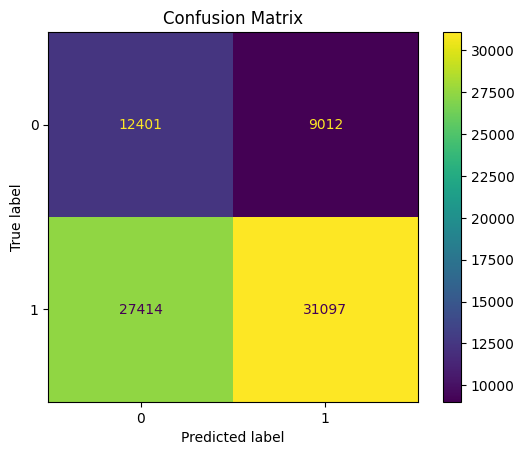

In [49]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
# Pass the model's classes if available, otherwise use unique values from y_test
display_labels = model.classes_ if hasattr(model, 'classes_') else sorted(y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the confusion matrix
disp.plot()

# Add a title to the plot
plt.title("Confusion Matrix")

# Display the plot
plt.show()

## Roc curve and auc

### Subtask:
Plot the Receiver Operating Characteristic (ROC) curve to illustrate the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) at various threshold settings. Calculate the Area Under the Curve (AUC) as a single metric summarizing the overall performance.


**Reasoning**:
Calculate predicted probabilities, compute ROC curve components, calculate AUC, and plot the ROC curve with the calculated AUC value.



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


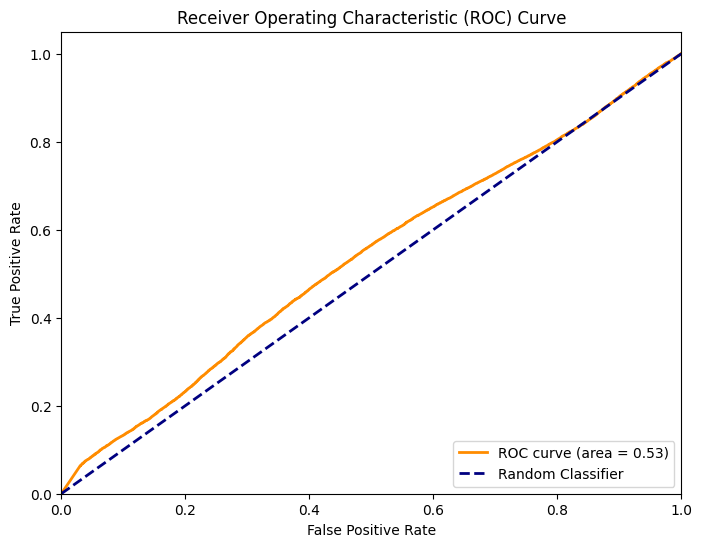

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the predicted probabilities for the positive class (class 1) on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute the false positive rates (fpr), true positive rates (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision-recall curve

### Subtask:
Plot the precision-recall curve, which is particularly useful for imbalanced datasets, to visualize the trade-off between precision and recall at different thresholds.


**Reasoning**:
Compute and plot the precision-recall curve as per the instructions.



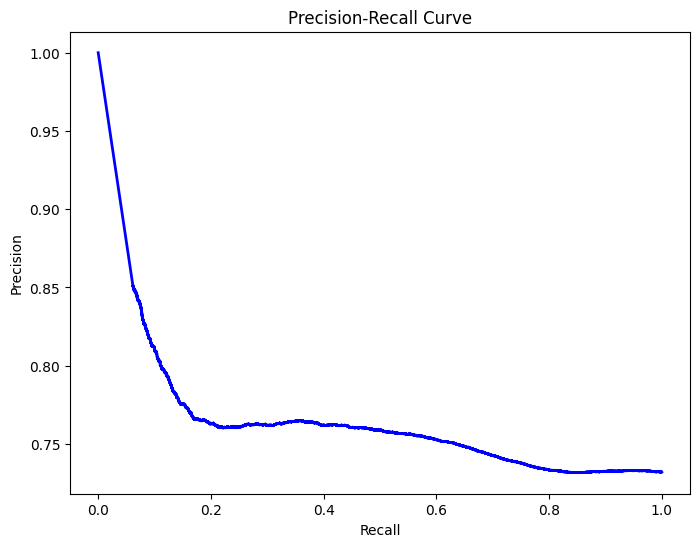

In [51]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision, recall, and thresholds for the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

## Distribution plots of features

### Subtask:
Visualize the distribution of key features, potentially separated by the target variable, to understand how well the features might separate the classes.


**Reasoning**:
Select key numerical features and visualize their distributions in the training and testing sets, including distributions separated by the target variable, to understand feature distributions and their potential to separate classes.



Visualizing distributions for key features: ['CRS_DEP_TIME_UTC_MIN', 'CRS_ARR_TIME_UTC_MIN', 'DEP_TIME_UTC_MIN', 'MONTH', 'ARR_wind_speed_kt', 'FLIGHT_DIRECTION_VECTOR']


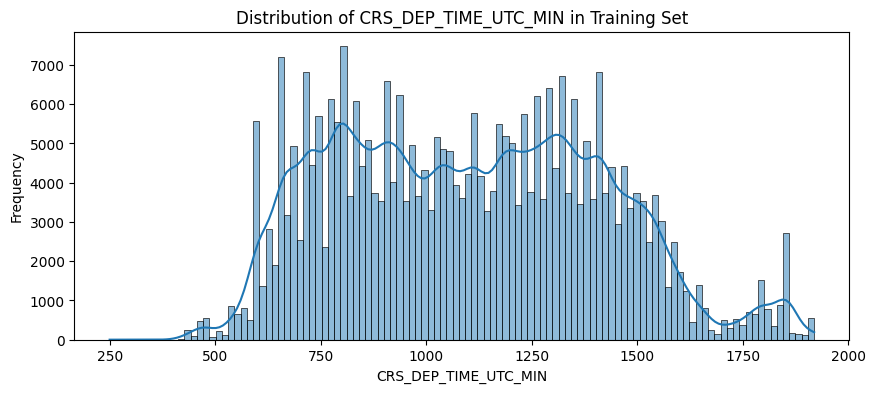

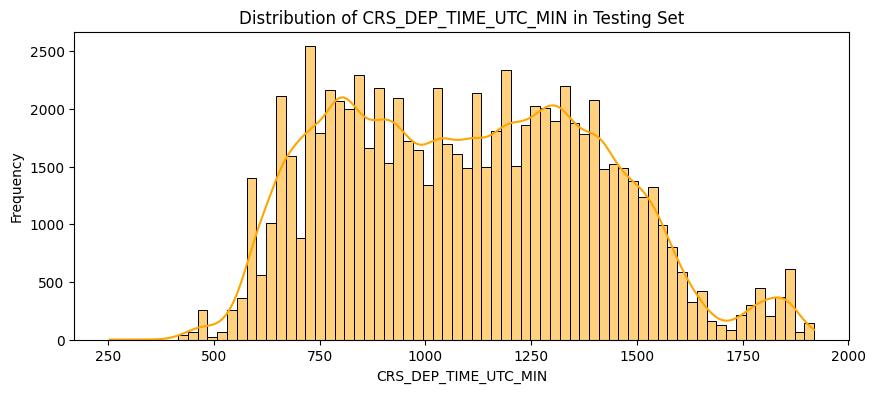

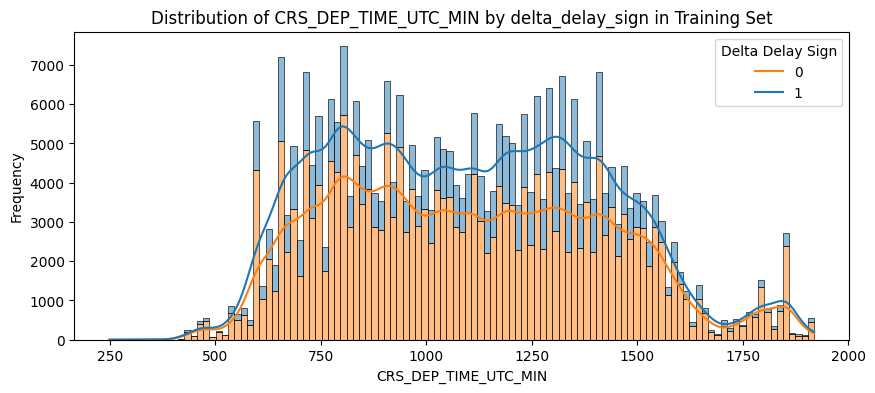

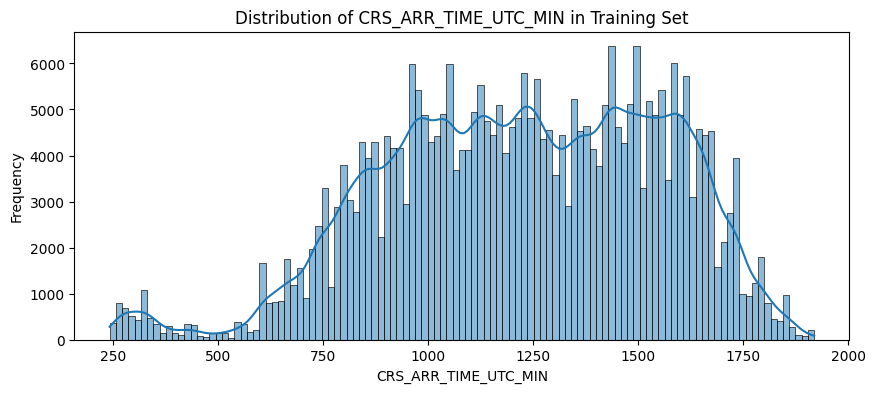

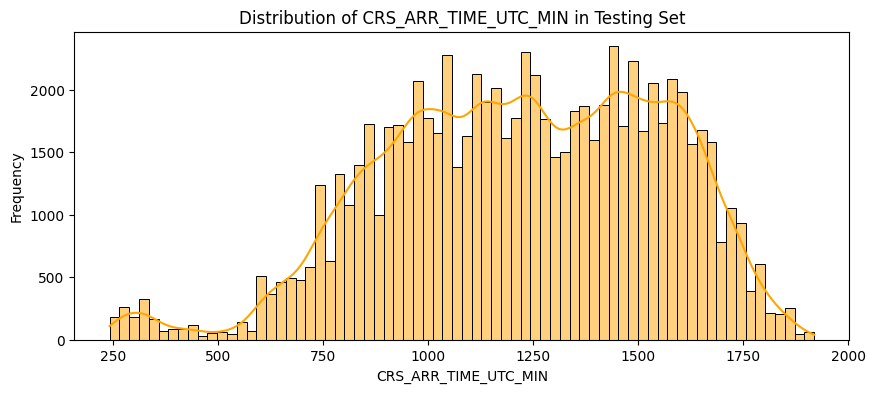

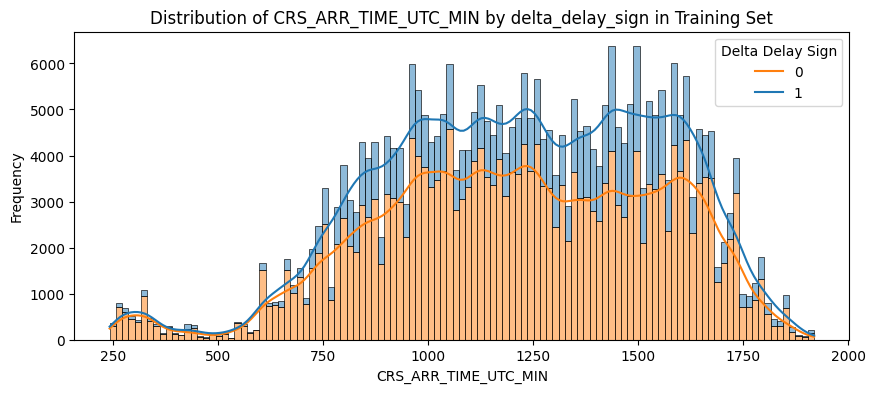

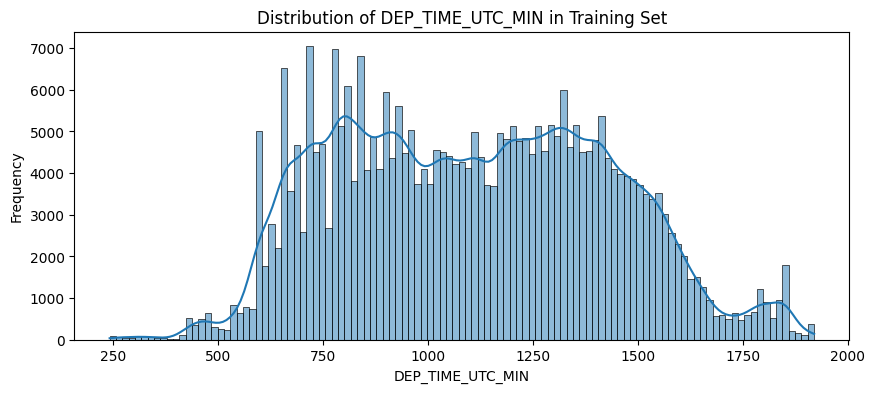

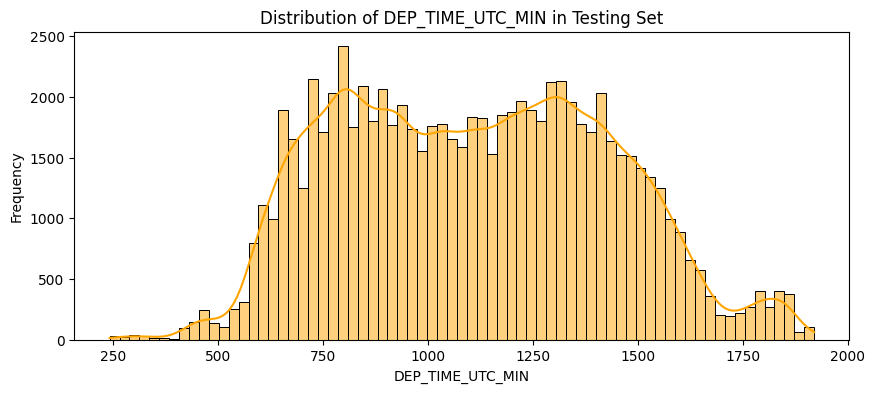

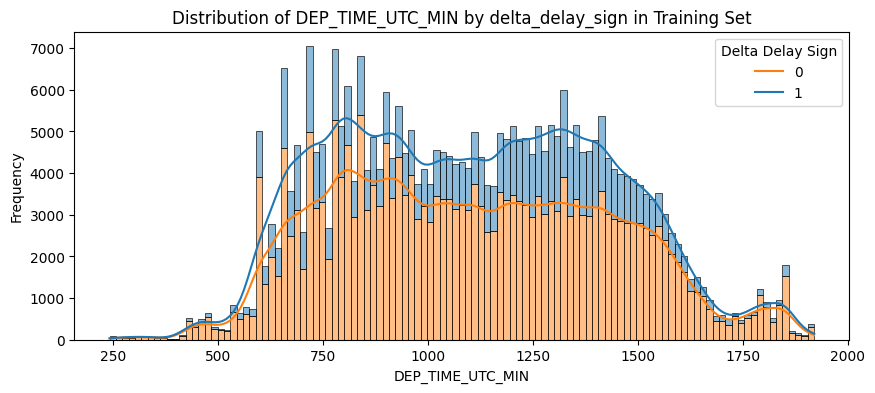

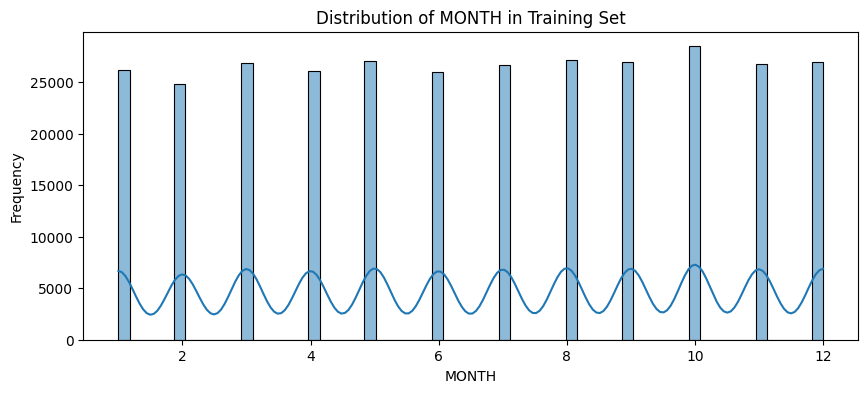

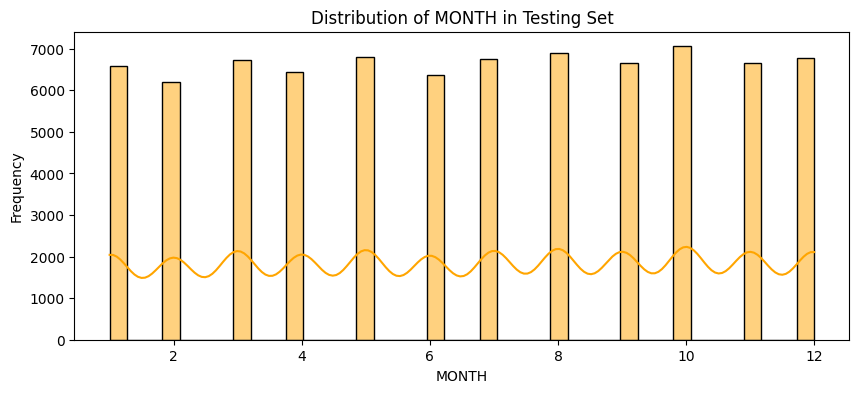

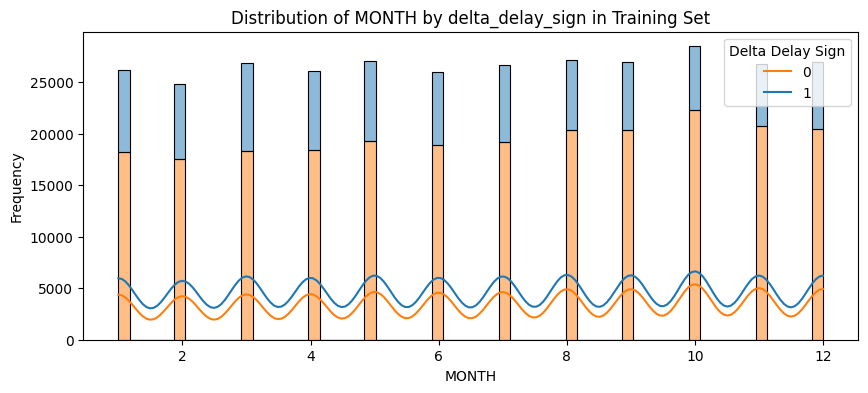

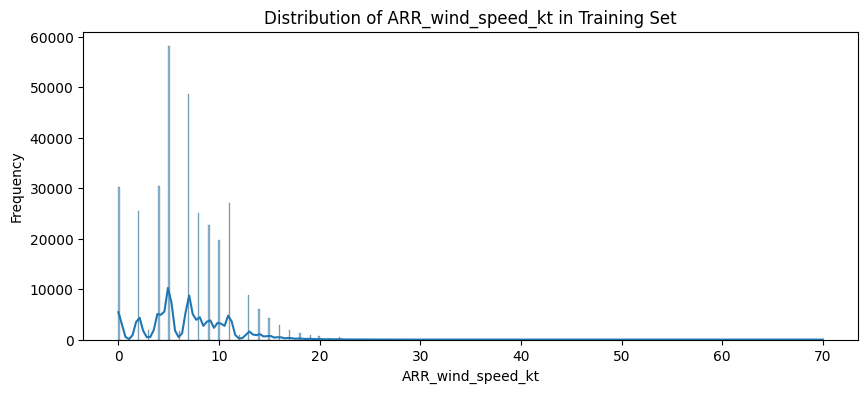

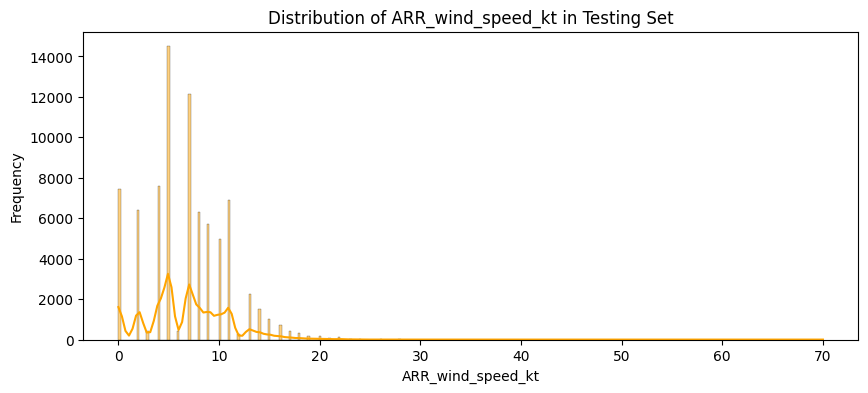

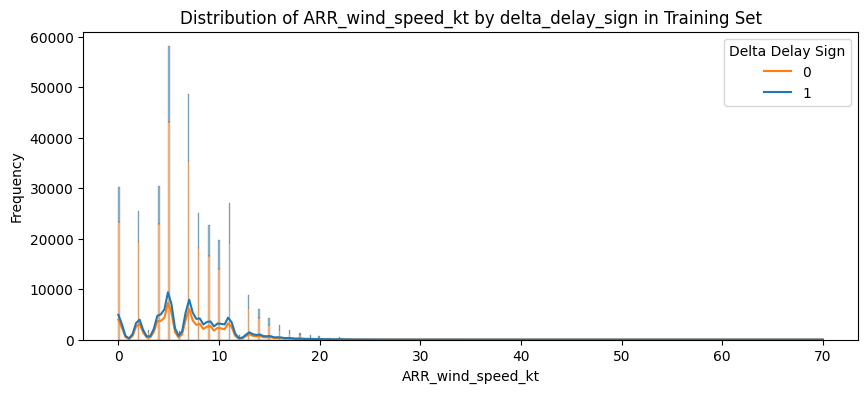

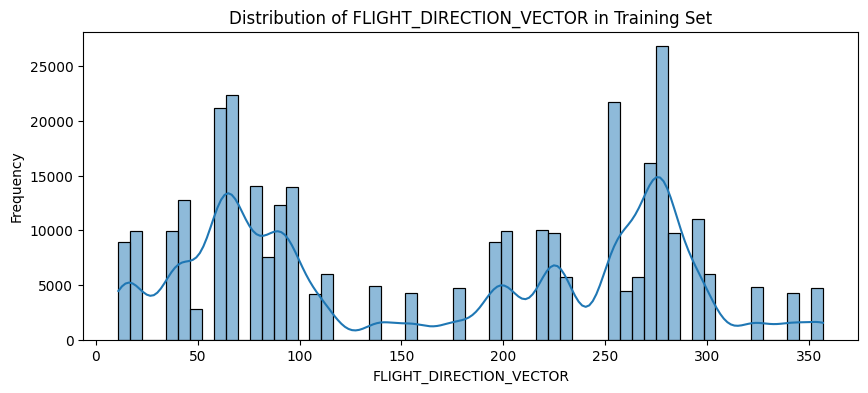

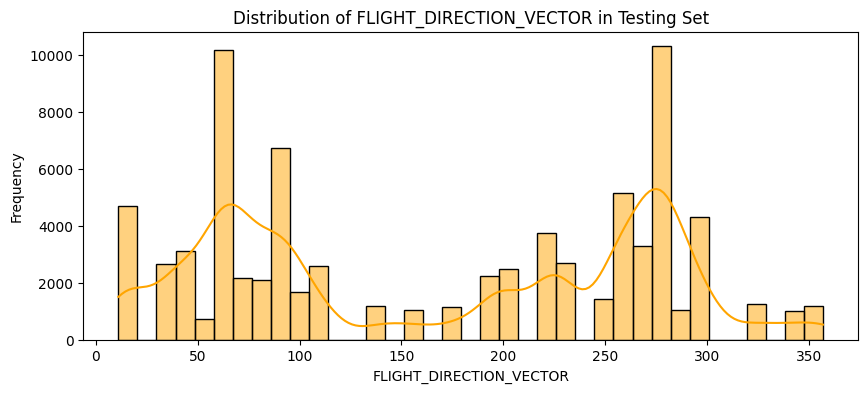

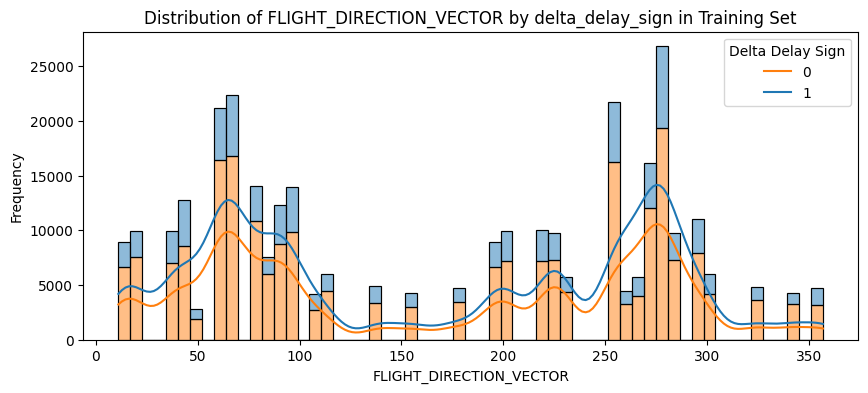

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few key numerical features based on feature importances
# Choosing the top 5 based on absolute value of coefficients from the previous step
# Ensure these columns exist in X_train and X_test
key_features = sorted_feature_importances.head(5).index.tolist()
# Add one more feature for variety if there are enough features
if len(sorted_feature_importances) > 5:
    key_features.append(sorted_feature_importances.tail(1).index[0])


print("Visualizing distributions for key features:", key_features)

# Combine X_train and y_train for plotting distributions by target variable
X_train_with_target = X_train[key_features].copy()
X_train_with_target['delta_delay_sign'] = y_train.values


for feature in key_features:
    # Plot distribution in X_train
    plt.figure(figsize=(10, 4))
    sns.histplot(data=X_train, x=feature, kde=True)
    plt.title(f'Distribution of {feature} in Training Set')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

    # Plot distribution in X_test
    plt.figure(figsize=(10, 4))
    sns.histplot(data=X_test, x=feature, kde=True, color='orange')
    plt.title(f'Distribution of {feature} in Testing Set')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

    # Plot distribution by target variable in X_train
    plt.figure(figsize=(10, 4))
    sns.histplot(data=X_train_with_target, x=feature, hue='delta_delay_sign', kde=True, multiple='stack')
    plt.title(f'Distribution of {feature} by delta_delay_sign in Training Set')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Delta Delay Sign', labels=['0', '1'])
    plt.show()

## Visualize feature importances

### Subtask:
Create a bar plot to visualize the magnitude of the feature importances (coefficients in the case of Logistic Regression) to clearly see which features have the most influence on the model.


**Reasoning**:
Create a bar plot to visualize the magnitude of the feature importances (coefficients) using the sorted_feature_importances Series.



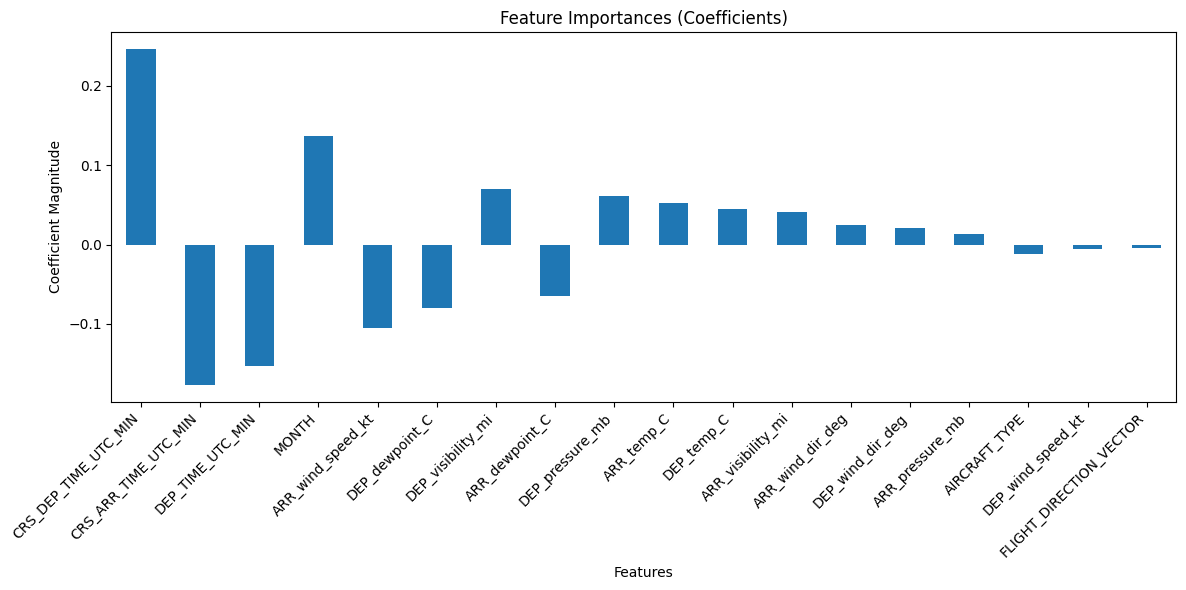

In [53]:
# Create a bar plot of the sorted_feature_importances Series
plt.figure(figsize=(12, 6))
sorted_feature_importances.plot(kind='bar')

# Set the title of the plot
plt.title('Feature Importances (Coefficients)')

# Set the x-axis label
plt.xlabel('Features')

# Set the y-axis label
plt.ylabel('Coefficient Magnitude')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right') # Rotate and align labels

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   The confusion matrix successfully visualized the counts of true positives, true negatives, false positives, and false negatives.
*   The ROC curve and AUC were calculated and plotted, with the AUC providing a single metric summary of the model's overall performance.
*   A precision-recall curve was plotted to illustrate the trade-off between precision and recall, which is especially valuable for imbalanced datasets.
*   Distribution plots of key features showed their distribution in the training and testing sets, and also separated by the target variable, providing insights into class separation.
*   A bar plot of feature importances (coefficients) visually represented the magnitude of influence each feature has on the model.

### Insights or Next Steps

*   Analyze the distribution plots of features by target variable to identify features that show clear separation between the classes, as these are likely strong predictors.
*   Examine the feature importance plot to identify the most influential features, which can guide further feature engineering or selection efforts.
